In [13]:
packageVersion('IRdisplay')
packageVersion('IRkernel')
packageVersion('repr')

[1] ‘0.4.9000’

[1] ‘0.6’

[1] ‘0.9’

In [14]:
clean_column <- function(col) {
    col <- sapply(col, function(x) toString(x))
    col <- sapply(col, function(x) tolower(x))
    col <- sapply(col, function(x) gsub("-", "", x))
    col <- sapply(col, function(x) gsub(" ", "", x))
    return(col)
}

In [15]:
payment_per_period <- function(principal_value, interest_rate, number_of_periods) {
    interest_rate * principal_value / (1 - (1 + interest_rate)^(-number_of_periods))
}

In [16]:
MAKES_WANTED = c("toyota", "honda", "chevrolet", "mazda", "nissan", "subaru", "hyundai", "kia", "acura", "lexus")
MODELS_WANTED = c("rav4", "crv", "accord", "camry", "hrv", "4runner", "rogue", "murano", "santafe")
MIN_YEAR = 2010
MAX_KILOMETERS = 100000

# Parse and Clean Data

In [17]:
sources <- lapply(
    c("kijiji", 
      "ottawahonda", 
      "tonygrahamtoyota", 
      "jimtubman", 
      "caronauto", 
      "belairlexustoyota", 
      "manualcollection"
     ),
    function(x) {
        paste("data/", x, "_cars.csv", sep="")
    }
)

i <- 1
write(paste("reading", sources[[i]]), stdout())
raw_df <- read.csv(sources[[i]])
while (i < length(sources)) {
    i = i + 1
    write(paste("reading", sources[[i]]), stdout())
    raw_df <- rbind(raw_df, read.csv(sources[[i]]))
}

reading data/kijiji_cars.csv
reading data/ottawahonda_cars.csv


Warning message:
In `[<-.factor`(`*tmp*`, ri, value = c(143485, 81318, 43108, 18424, : invalid factor level, NA generated

reading data/tonygrahamtoyota_cars.csv


Warning message:
In `[<-.factor`(`*tmp*`, ri, value = c(38888L, 33318L, 34243L, 31313L, : invalid factor level, NA generated

reading data/jimtubman_cars.csv


Warning message:
In `[<-.factor`(`*tmp*`, ri, value = c(2014L, 2014L, 2014L, 2016L, : invalid factor level, NA generated

reading data/caronauto_cars.csv


Warning message:
In scan(file, what, nmax, sep, dec, quote, skip, nlines, na.strings, : EOF within quoted string

reading data/belairlexustoyota_cars.csv
reading data/manualcollection_cars.csv


Warning message:
In `[<-.factor`(`*tmp*`, ri, value = 5000L): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = 21000L): invalid factor level, NA generated

In [18]:
raw_df$make <- clean_column(raw_df$make)
raw_df$model <- clean_column(raw_df$model)
    
raw_df$price <- as.character(raw_df$price)
raw_df$price <- lapply(raw_df$price, function(x) gsub("\\$", "", x))
raw_df$price <- lapply(raw_df$price, function(x) gsub("\\,", "", x))
raw_df$price <- as.numeric(raw_df$price)
    
raw_df$kilometers <- as.character(raw_df$kilometers)
raw_df$kilometers <- lapply(raw_df$kilometers, function(x) gsub("km", "", x))
raw_df$kilometers <- lapply(raw_df$kilometers, function(x) gsub(",", "", x))
raw_df$kilometers <- as.numeric(raw_df$kilometers)
    
raw_df$age <- 2016 - as.numeric(raw_df$year)
    
raw_df <- raw_df[, !(names(raw_df) %in% c("description"))]

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs 

In [19]:
nrow(raw_df)

[1] 1330

## Add Loan Financing Data 

In [20]:
raw_df$sales_tax <- raw_df$price * 0.15
raw_df$total_price <- raw_df$price + raw_df$sales_tax
    
raw_df$five_yr_six_prcnt_monthly <- sapply(raw_df$total_price, function(x) payment_per_period(x, 0.06 / 12, 60))
raw_df$three_yr_six_prcnt_monthly <- sapply(raw_df$total_price, function(x) payment_per_period(x, 0.06 / 12, 36))
raw_df$five_yr_one_prcnt_monthly <- sapply(raw_df$total_price, function(x) payment_per_period(x, 0.01 / 12, 60))
raw_df$three_yr_one_prcnt_monthly <- sapply(raw_df$total_price, function(x) payment_per_period(x, 0.01 / 12, 36))

In [21]:
colnames(raw_df)

[1] "domain"                     "used"                      
 [3] "date_listed"                "url"                       
 [5] "make"                       "title"                     
 [7] "year"                       "kilometers"                
 [9] "model"                      "price"                     
[11] "age"                        "sales_tax"                 
[13] "total_price"                "five_yr_six_prcnt_monthly" 
[15] "three_yr_six_prcnt_monthly" "five_yr_one_prcnt_monthly" 
[17] "three_yr_one_prcnt_monthly"

## Filter Down to Desired

In [22]:
raw_df <- raw_df[raw_df$make %in% MAKES_WANTED, ]
raw_df <- raw_df[raw_df$kilometers < MAX_KILOMETERS, ]
raw_df <- raw_df[raw_df$year > MIN_YEAR, ]
nrow(raw_df)

[1] 366

## Rename

In [23]:
df <- raw_df

## Join with Fuel and Maintenance Data

In [24]:
eff <- read.csv("data/nrcan_fuel_ratings.csv")
nrow(eff)

[1] 140196

In [25]:
eff <- eff[!duplicated(eff$title), ]
eff$make <- clean_column(eff$make)
eff$model <- clean_column(eff$model)
nrow(eff)
colnames(eff)

[1] 3343

[1] "engine_size_litres"       "domain"                  
 [3] "cylinders"                "title"                   
 [5] "transmission"             "year"                    
 [7] "make"                     "ranking_overall"         
 [9] "lphkm_city"               "ranking_class"           
[11] "lphkm_hwy"                "url"                     
[13] "model_class"              "fuel"                    
[15] "estimated_fuel_cost_year" "model"

In [26]:
library(dplyr)

# assume all efficiencys are equal accross years
eff <- eff[, !(names(eff) %in% c("year"))]

df <- dplyr::left_join(
    df, 
    eff, 
    by=c("make" = "make", "model" = "model")
)  
nrow(df)
colnames(df)

Warning message:
: package ‘dplyr’ was built under R version 3.2.5
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] 366

[1] "domain.x"                   "used"                      
 [3] "date_listed"                "url.x"                     
 [5] "make"                       "title.x"                   
 [7] "year"                       "kilometers"                
 [9] "model"                      "price"                     
[11] "age"                        "sales_tax"                 
[13] "total_price"                "five_yr_six_prcnt_monthly" 
[15] "three_yr_six_prcnt_monthly" "five_yr_one_prcnt_monthly" 
[17] "three_yr_one_prcnt_monthly" "engine_size_litres"        
[19] "domain.y"                   "cylinders"                 
[21] "title.y"                    "transmission"              
[23] "ranking_overall"            "lphkm_city"                
[25] "ranking_class"              "lphkm_hwy"                 
[27] "url.y"                      "model_class"               
[29] "fuel"                       "estimated_fuel_cost_year"

In [27]:
maintenance <- read.csv("data/maintenance_costs_manual_collection.csv")
maintenance$make <- clean_column(maintenance$make)
maintenance$model <- clean_column(maintenance$model)
nrow(maintenance)
colnames(maintenance)

[1] 14

[1] "make"                    "model"                  
 [3] "year"                    "five_year_maintenance"  
 [5] "eight_year_maintenance"  "five_year_depreciation" 
 [7] "eight_year_depreciation" "five_year_fuel"         
 [9] "msrp_lower"              "msrp_upper"             
[11] "predicted_reliability"

In [28]:
# assume all maintenance is equal across years
maintenance <- maintenance[, !(names(maintenance) %in% c("year"))]

df <- left_join(
    df, 
    maintenance, 
    by=c("make" = "make", "model" = "model")
)  
nrow(df)
colnames(df)

[1] 366

[1] "domain.x"                   "used"                      
 [3] "date_listed"                "url.x"                     
 [5] "make"                       "title.x"                   
 [7] "year"                       "kilometers"                
 [9] "model"                      "price"                     
[11] "age"                        "sales_tax"                 
[13] "total_price"                "five_yr_six_prcnt_monthly" 
[15] "three_yr_six_prcnt_monthly" "five_yr_one_prcnt_monthly" 
[17] "three_yr_one_prcnt_monthly" "engine_size_litres"        
[19] "domain.y"                   "cylinders"                 
[21] "title.y"                    "transmission"              
[23] "ranking_overall"            "lphkm_city"                
[25] "ranking_class"              "lphkm_hwy"                 
[27] "url.y"                      "model_class"               
[29] "fuel"                       "estimated_fuel_cost_year"  
[31] "five_year_maintenance"      "eight_year_maintenance"    
[33] "five_year_depreciation"     "eight_year_depreciation"   
[35] "five_year_fuel"             "msrp_lower"                
[37] "msrp_upper"                 "predicted_reliability"

In [29]:
summary(df$kilometers)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      1       5   21450   28770   46920   93700      52 

# Overview

Warning message:
: Removed 213 rows containing missing values (geom_point).

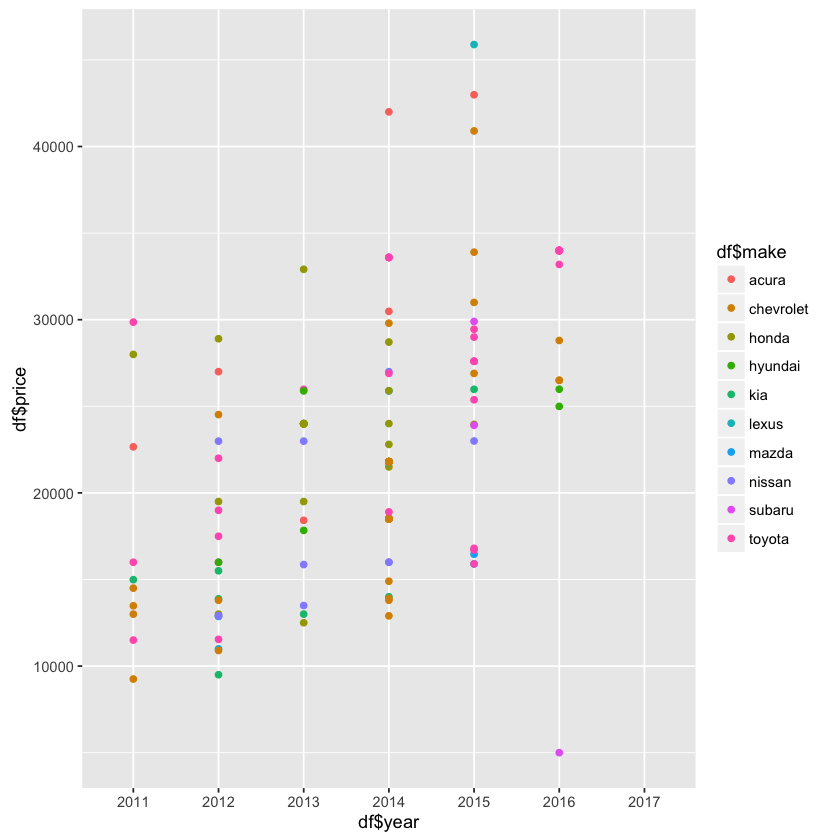

In [30]:
library(ggplot2)
ggplot(df) + geom_point(aes(x=df$age, y=df$price, colour=df$make))

# Toyota

Warning message:
: Removed 200 rows containing missing values (geom_label).

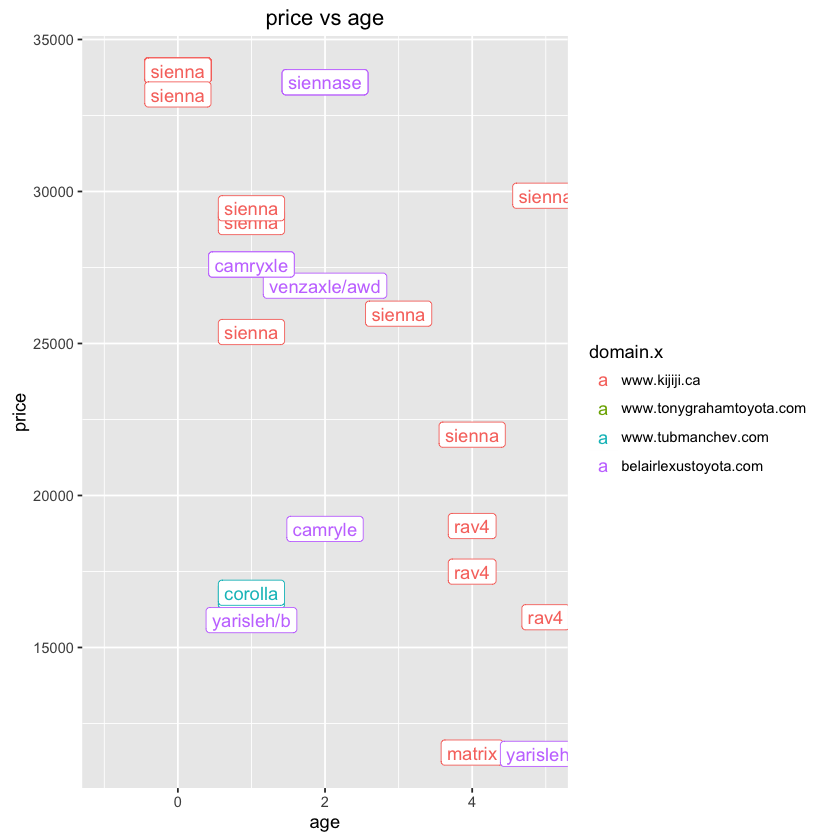

In [31]:
library(ggplot2)
plot_price_vs_age <- function(dataframe) {
    p <- ggplot(dataframe, aes(age, price, label=model, color=domain.x))
    p + geom_label() + ggtitle("price vs age")  
}
tmp <- df[df$make == "toyota", ]
plot_price_vs_age(tmp)

In [32]:
colnames(df)


[1] "domain.x"                   "used"                      
 [3] "date_listed"                "url.x"                     
 [5] "make"                       "title.x"                   
 [7] "year"                       "kilometers"                
 [9] "model"                      "price"                     
[11] "age"                        "sales_tax"                 
[13] "total_price"                "five_yr_six_prcnt_monthly" 
[15] "three_yr_six_prcnt_monthly" "five_yr_one_prcnt_monthly" 
[17] "three_yr_one_prcnt_monthly" "engine_size_litres"        
[19] "domain.y"                   "cylinders"                 
[21] "title.y"                    "transmission"              
[23] "ranking_overall"            "lphkm_city"                
[25] "ranking_class"              "lphkm_hwy"                 
[27] "url.y"                      "model_class"               
[29] "fuel"                       "estimated_fuel_cost_year"  
[31] "five_year_maintenance"      "eight_year_maintenance"    
[33] "five_year_depreciation"     "eight_year_depreciation"   
[35] "five_year_fuel"             "msrp_lower"                
[37] "msrp_upper"                 "predicted_reliability"

Warning message:
: Removed 200 rows containing missing values (geom_label).

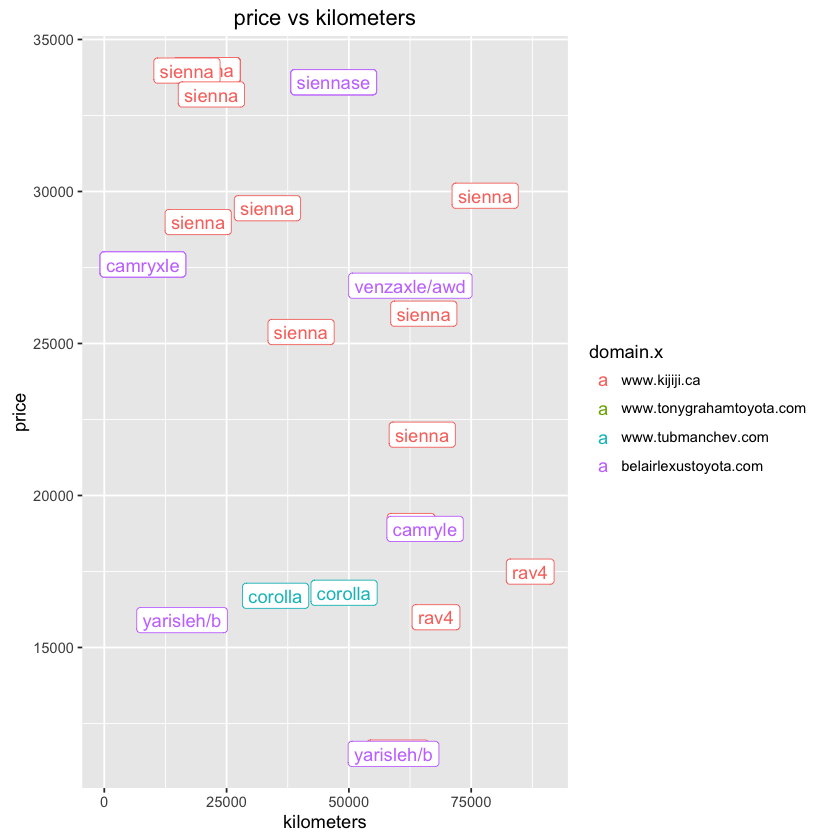

In [33]:
plot_price_vs_kilometers <- function(dataframe) {
    dataframe <- dataframe[dataframe$kilometers < 200000, ]
    p <- ggplot(dataframe, aes(kilometers, price, label=model, color=domain.x))
    p <- p + geom_label() + ggtitle("price vs kilometers")
    p
}
tmp <- df[df$make == "toyota", ]
plot_price_vs_kilometers(tmp)

# Honda

Warning message:
: Removed 54 rows containing missing values (geom_label).

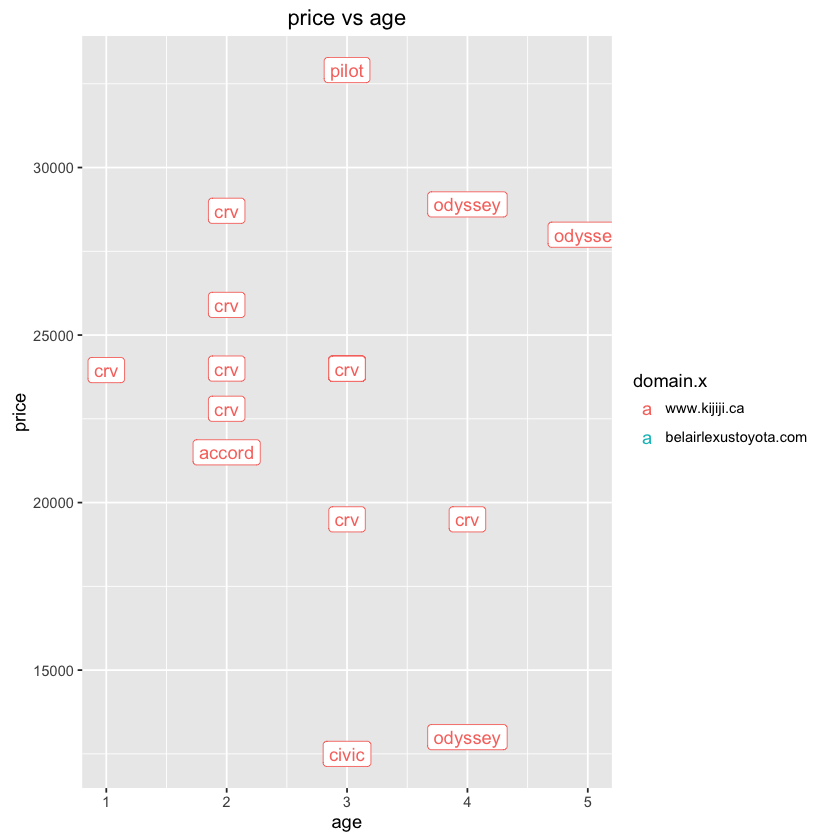

In [34]:
tmp <- df[df$make == "honda", ]
plot_price_vs_age(tmp)

Warning message:
: Removed 54 rows containing missing values (geom_label).

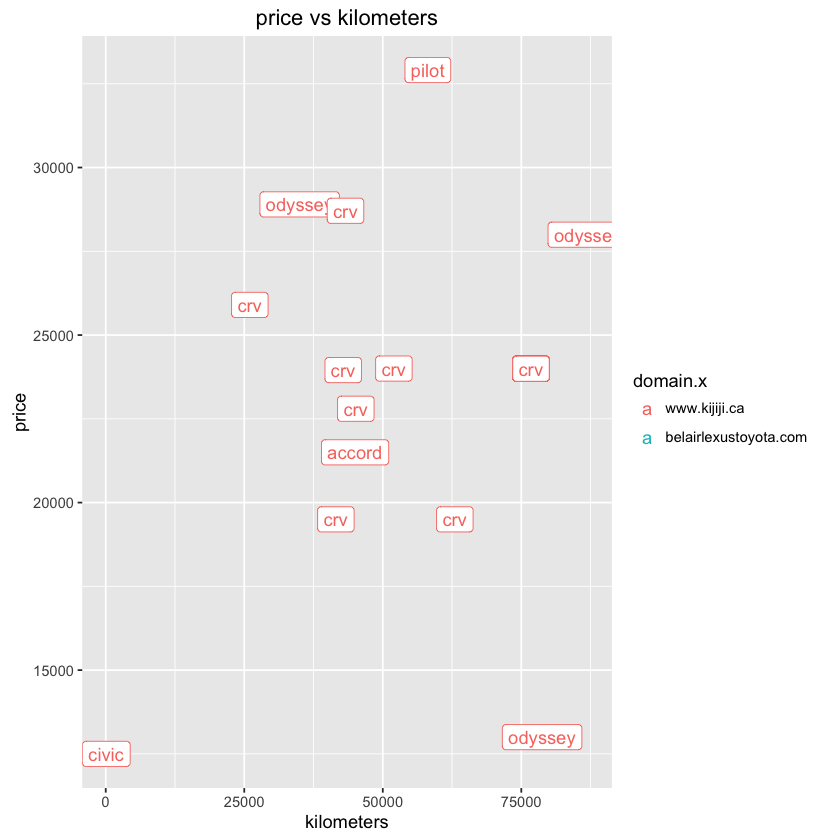

In [35]:
tmp <- df[df$make == "honda", ]
plot_price_vs_kilometers(tmp)

In [36]:
write.csv(df, file="data/full_data_output.csv")

## Desirability Heuristic

In [37]:
heuristic_columns = c(
    "kilometers", 
    "five_yr_six_prcnt_monthly", 
    "age", 
    "lphkm_hwy", 
    "lphkm_city"
)
#    "five_year_maintenance",
#    "five_year_depreciation"
heuristic_weights = c(
)
complete_df <- df[complete.cases(df[, heuristic_columns]), ]

In [38]:
max_values = apply(complete_df[, heuristic_columns], 2, function(column) { max(as.numeric(column), na.rm=TRUE)})
max_values

kilometers five_yr_six_prcnt_monthly                       age 
               93700.0000                  955.7402                    5.0000 
                lphkm_hwy                lphkm_city 
                  13.1000                   18.8000

In [39]:
complete_df$heuristic <- apply(complete_df, 1, function(record) {
    # lower is better
    x = 0
    for (name in names(max_values)) {
         x = x + (as.numeric(record[name]) / max_values[name])^2
    }
    return(x)
})

In [40]:
complete_df <- complete_df[order(complete_df$heuristic), ]
complete_df

,domain.x,used,date_listed,url.x,make,title.x,year,kilometers,model,price,⋯,estimated_fuel_cost_year,five_year_maintenance,eight_year_maintenance,five_year_depreciation,eight_year_depreciation,five_year_fuel,msrp_lower,msrp_upper,predicted_reliability,heuristic
308,www.tubmanchev.com,NA,NA,http://www.tubmanchev.com/used/vehicle/2015-toyota-corolla-id8012211.htm,toyota,NA,2015,35015,corolla,16700,⋯,$1679,NA,NA,NA,NA,NA,NA,NA,NA,0.7860187
34,www.kijiji.ca,NA,15-Sep-16,http://www.kijiji.ca/v-cars-trucks/ottawa/2013-honda-civic/1199736301,honda,2013 Honda Civic,2013,100,civic,12500,⋯,$1657,1200,2750,11000,14000,4500,16155,27155,3,0.9028042
311,www.tubmanchev.com,NA,NA,http://www.tubmanchev.com/used/vehicle/2015-toyota-corolla-id8013590.htm,toyota,NA,2015,49018,corolla,16800,⋯,$1679,NA,NA,NA,NA,NA,NA,NA,NA,0.9218583
37,www.kijiji.ca,NA,21-Aug-16,http://www.kijiji.ca/v-cars-trucks/ottawa/2014-nissan-juke-sv-fwd/1192181636,nissan,2014 Nissan Juke SV FWD,2014,25832,juke,15999,⋯,$2133,NA,NA,NA,NA,NA,NA,NA,NA,0.9664418
80,www.kijiji.ca,NA,16-Sep-16,http://www.kijiji.ca/v-cars-trucks/ottawa/2016-hyundai-tucson-premium/1199907643,hyundai,2016 Hyundai Tucson Premium,2016,24000,tucson,24995,⋯,$2027,NA,NA,NA,NA,NA,NA,NA,NA,1.0898626
33,www.kijiji.ca,NA,05-Sep-16,http://www.kijiji.ca/v-cars-trucks/ottawa/2014-nissan-altima-2-5-s-bluetooth-km:-56k/1154393170,nissan,2014 Nissan Altima 2.5 S BLUETOOTH KM 56K!!,2014,56811,altima,15995,⋯,$1657,NA,NA,NA,NA,NA,NA,NA,NA,1.1042012
36,www.kijiji.ca,NA,15-Sep-16,http://www.kijiji.ca/v-cars-trucks/ottawa/2013-nissan-sentra-1-8-sv/1153836834,nissan,2013 Nissan Sentra 1.8 SV,2013,42201,sentra,13495,⋯,$1700,1400,3000,14000,16750,4750,15900,26000,1,1.1293784
319,belairlexustoyota.com,,,http://belairlexustoyota.com/cars/view/2nn/2015-subaru-impreza/,subaru,2015 Subaru Impreza,2015,20701,impreza,23900,⋯,$2202,NA,NA,NA,NA,NA,NA,NA,NA,1.1901661
48,www.kijiji.ca,NA,01-Sep-16,http://www.kijiji.ca/v-cars-trucks/ottawa/2015-honda-cr-v-heated-seats-reverse-camera/1195456742,honda,2015 Honda CR-V HEATED SEATS REVERSE CAMERA,2015,42867,crv,23955,⋯,$1984,1500,3000,16500,NA,5750,26290,37090,NA,1.1965660
55,www.kijiji.ca,NA,16-Sep-16,http://www.kijiji.ca/v-cars-trucks/ottawa/2014-kia-sorento/1194114783,kia,2014 KIA SORENTO,2014,33260,sorento,13999,⋯,$2245,NA,NA,NA,NA,NA,NA,NA,NA,1.2070151


In [41]:
write.csv(complete_df, file="data/heuristic_output.csv")